# Clustering Methodology

## Objective

Use K-Means to cluster discs into a small set of archetypes using flight features (SPEED, GLIDE, TURN, FADE, STABILITY).  
Choose K via an elbow + silhouette sweep, then save cluster labels for Notebook 03 (classification).

*Key insight:* Here clustering **discs** (proxy); with GameProofer data is the same workflow used to cluster **players/throws**.


## Setup

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from matplotlib.patches import Ellipse

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Load Cleaned Data

In [2]:
# Load cleaned data from EDA
processed_path = Path('../data/processed/disc_golf_cleaned.csv')
if not processed_path.exists():
    raise FileNotFoundError(
        f"Cleaned dataset not found at {processed_path}. Run 01_exploratory_analysis.ipynb first."
    )

df = pd.read_csv(processed_path)
print(f"Loaded {len(df):,} disc models and {len(df.columns)} columns")
print(f"Columns: {list(df.columns)}")

Loaded 1,175 disc models and 16 columns
Columns: ['MOLD', 'DISC TYPE', 'SPEED', 'GLIDE', 'TURN', 'FADE', 'STABILITY', 'DIAMETER (cm)', 'HEIGHT (cm)', 'RIM DEPTH (cm)', 'RIM WIDTH (cm)', 'INSIDE RIM DIAMETER (cm)', 'RIM DEPTH / DIAMETER RATION (%)', 'RIM CONFIGURATION', 'BEAD', 'DISC_TYPE_CLEAN']


## Feature Selection for Clustering

### Why these features

Use the standard flight ratings (SPEED, GLIDE, TURN, FADE, STABILITY) because they directly summarize how a disc is expected to fly. This is the closest available proxy to “throwing characteristics” in this specs-only dataset.

This keeps the clustering focused on performance behavior rather than manufacturing dimensions. It also maps cleanly to the intended real application where the same workflow would cluster *players* using measured throw characteristics.


In [3]:
# Select relevant features for clustering
clustering_features = ['SPEED', 'GLIDE', 'TURN', 'FADE', 'STABILITY']

# Check if features exist
available_features = [f for f in clustering_features  if f in df.columns]
if not available_features:
    raise ValueError(f"Missing features {not available_features} required for clustering")

print(f"Using features: {available_features}")

# Create feature matrix
X = df[available_features].copy()

# Handle missing values if any
if X.isnull().sum().sum() > 0:
    print(f"\nWARNING: {X.isnull().sum().sum()} missing values found")
    print("Filling with column means...")
    X = X.fillna(X.mean())

print(f"\nFeature matrix shape: {X.shape}")
print(f"\nFeature statistics:")
X.describe()

Using features: ['SPEED', 'GLIDE', 'TURN', 'FADE', 'STABILITY']

Feature matrix shape: (1175, 5)

Feature statistics:


,SPEED,GLIDE,TURN,FADE,STABILITY
count,1175.000000,1175.000000,1175.000000,1175.000000,1175.000000
mean,6.985532,4.291064,-0.839574,2.014894,1.173617
std,3.676466,1.110181,1.122030,1.133728,1.890662
min,1.000000,0.000000,-5.000000,0.000000,-4.000000
25%,4.000000,4.000000,-1.000000,1.000000,0.000000
50%,7.000000,4.500000,-0.500000,2.000000,1.000000
75%,10.000000,5.000000,0.000000,3.000000,2.500000
max,14.500000,7.000000,2.000000,6.000000,7.000000


## Feature Standardization

Scale features to have mean=0, std=1. Critical for K-Means because it uses Euclidean distance.

In [4]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\nScaled data shape: {X_scaled.shape}")
print(f"Mean after scaling: {X_scaled.mean(axis=0).round(4)}")
print(f"Std after scaling: {X_scaled.std(axis=0).round(4)}")


Scaled data shape: (1175, 5)
Mean after scaling: [-0.  0.  0.  0.  0.]
Std after scaling: [1. 1. 1. 1. 1.]


## Determine Optimal Number of Clusters

Use Elbow Method and Silhouette Score to find optimal K.

In [5]:
# Test different numbers of clusters
K_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

print("Clustering evaluation complete")

Clustering evaluation complete


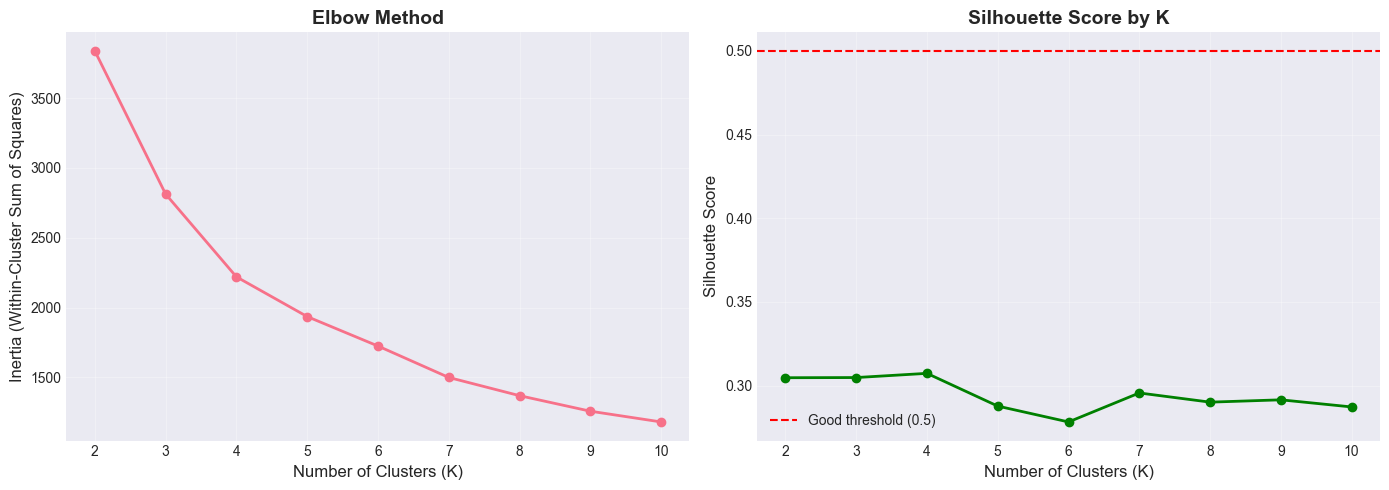


RECOMMENDATION: Optimal K = 4
Silhouette Score at K=4: 0.307


In [6]:
# Plot Elbow Curve and Silhouette Scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
axes[0].plot(K_range, inertias, marker='o', linewidth=2)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Silhouette scores
axes[1].plot(K_range, silhouette_scores, marker='o', linewidth=2, color='green')
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score by K', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].axhline(y=0.5, color='red', linestyle='--', label='Good threshold (0.5)')
axes[1].legend()

plt.tight_layout()
plt.show()

# Recommend optimal K
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nRECOMMENDATION: Optimal K = {optimal_k}")
print(f"Silhouette Score at K={optimal_k}: {max(silhouette_scores):.3f}")

## Train Final Clustering Model

In [7]:
# K-Means with optimal K
optimal_k = 4  # Or K_range[np.argmax(silhouette_scores)]

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df['Cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"Clustering complete with K = {optimal_k}")
print(f"\nCluster distribution:")
print(df['Cluster'].value_counts().sort_index())

# Final metrics
final_silhouette = silhouette_score(X_scaled, df['Cluster'])
final_ch_score = calinski_harabasz_score(X_scaled, df['Cluster'])

print(f"\nFinal Silhouette Score: {final_silhouette:.3f}")
print(f"Final Calinski-Harabasz Score: {final_ch_score:.2f}")

Clustering complete with K = 4

Cluster distribution:
Cluster
0    358
1    328
2    245
3    244
Name: count, dtype: int64

Final Silhouette Score: 0.307
Final Calinski-Harabasz Score: 642.48


## Cluster Interpretation

Analyze what each cluster represents by examining feature means.

In [8]:
cluster_n = df["Cluster"].value_counts().sort_index().rename("n")

cluster_means = df.groupby("Cluster")[available_features].mean()
cluster_stds = df.groupby("Cluster")[available_features].std()

global_mean = df[available_features].mean()
global_std = df[available_features].std(ddof=0).replace(0, np.nan)

cluster_z = cluster_means.sub(global_mean).div(global_std)

top_k = 3
top_features = (
    cluster_z.abs()
    .apply(lambda s: s.sort_values(ascending=False).head(top_k).index.to_list(), axis=1)
)
top_features = pd.DataFrame(
    top_features.to_list(),
    index=cluster_z.index,
    columns=[f"top_{i+1}" for i in range(top_k)],
)

disc_type_pct = (
    df.groupby("Cluster")["DISC TYPE"]
      .value_counts(normalize=True)
      .mul(100)
      .rename("pct")
      .reset_index()
)
disc_type_pct["rank"] = disc_type_pct.groupby("Cluster")["pct"].rank(method="first", ascending=False).astype(int)

disc_top3 = (
    disc_type_pct[disc_type_pct["rank"] <= 3]
    .sort_values(["Cluster", "rank"])
    .assign(label=lambda d: d["DISC TYPE"].astype(str) + " (" + d["pct"].round(1).astype(str) + "%)")
    .pivot(index="Cluster", columns="rank", values="label")
    .rename(columns={1: "type_1", 2: "type_2", 3: "type_3"})
)

summary = pd.concat([cluster_n, cluster_means.round(2)], axis=1)

print("Cluster mean/std:")
print(df.groupby("Cluster")[available_features].agg(["mean", "std"]).round(3))

print("\nCluster summary (n + means):")
print(summary)

print("\nCluster z-scores vs global mean:")
print(cluster_z.round(2))

print("\nMost differentiating features (|z| top 3):")
print(top_features)

print("\nTop disc types (% share):")
print(disc_top3)


Cluster mean/std:
          SPEED         GLIDE          TURN          FADE        STABILITY  \
           mean    std   mean    std   mean    std   mean    std      mean   
Cluster                                                                      
0         3.409  1.499  3.732  0.999 -0.307  0.507  1.267  0.692     0.959   
1        10.578  2.325  4.959  0.556 -0.863  0.693  2.395  0.598     1.532   
2         6.894  3.156  3.373  0.930  0.076  0.375  3.537  0.669     3.612   
3         7.496  2.862  5.135  0.759 -2.508  0.927  1.074  0.576    -1.443   

                
           std  
Cluster         
0        0.909  
1        0.953  
2        0.819  
3        1.025  

Cluster summary (n + means):
           n  SPEED  GLIDE  TURN  FADE  STABILITY
Cluster                                          
0        358   3.41   3.73 -0.31  1.27       0.96
1        328  10.58   4.96 -0.86  2.39       1.53
2        245   6.89   3.37  0.08  3.54       3.61
3        244   7.50   5.14 -2.51  1.

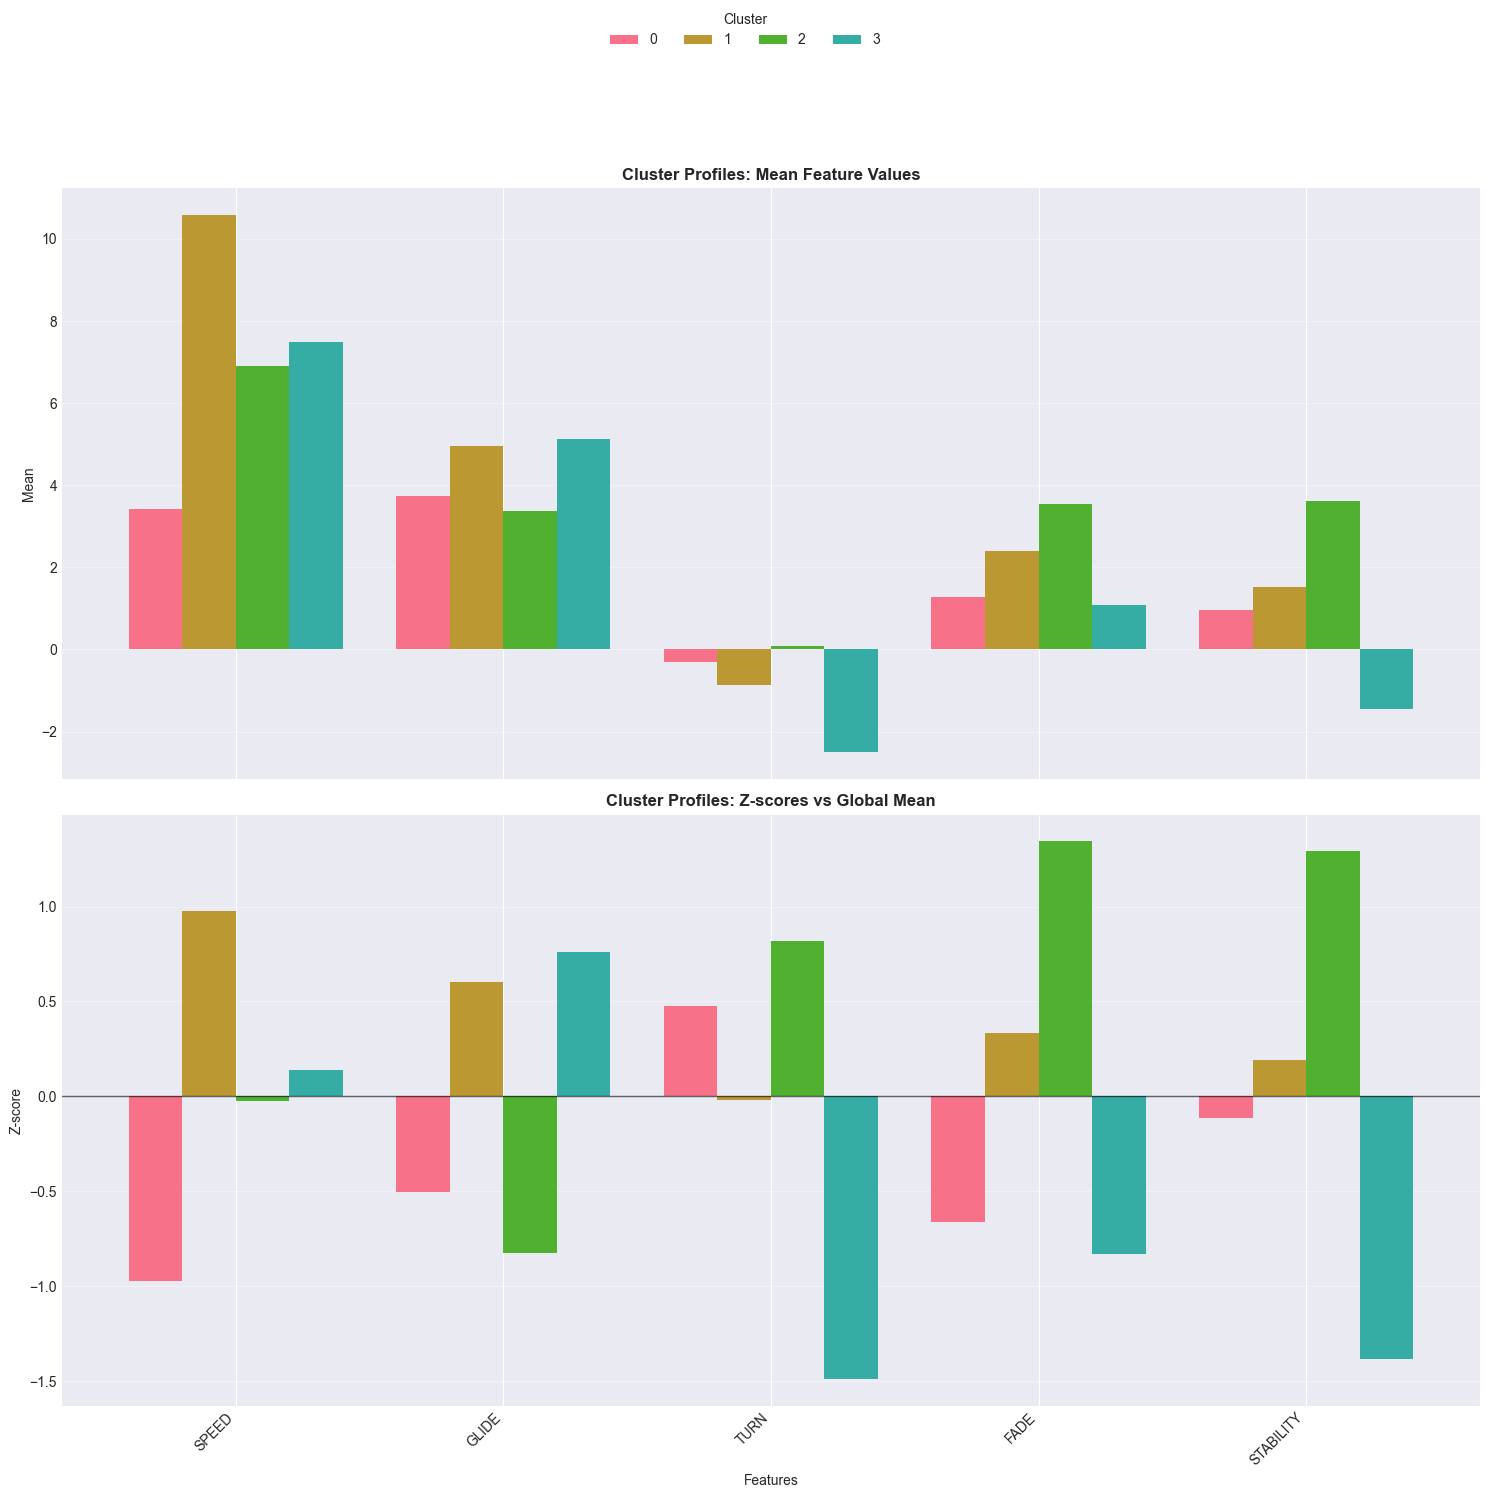

In [9]:
# Visualize cluster profiles

clustermeans = cluster_means.sort_index()
clusterz = cluster_z.loc[cluster_means.index]

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][:clustermeans.shape[0]]

fig, axes = plt.subplots(2, 1, figsize=(15, 15), sharex=True)

# Up: raw means
clustermeans.T.plot(kind="bar", ax=axes[0], width=0.8, color=colors)
axes[0].set_title("Cluster Profiles: Mean Feature Values", fontweight="bold")
axes[0].set_xlabel("Features")
axes[0].set_ylabel("Mean")
axes[0].grid(axis="y", alpha=0.3)

# Down: z-scores
clusterz.T.plot(kind="bar", ax=axes[1], width=0.8, color=colors)
axes[1].axhline(0, color="black", linewidth=1, alpha=0.6)
axes[1].set_title("Cluster Profiles: Z-scores vs Global Mean", fontweight="bold")
axes[1].set_xlabel("Features")
axes[1].set_ylabel("Z-score")
axes[1].grid(axis="y", alpha=0.3)

for ax in axes:
    ax.legend_.remove()
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Cluster", loc="upper center", ncol=len(labels), frameon=False)

plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right")
plt.setp(axes[1].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()


## Cluster Naming & Business Interpretation

In [10]:
# Interpret clusters based on characteristics
features = available_features  # ['SPEED','GLIDE','TURN','FADE','STABILITY']

# Core summaries
cluster_n = df.groupby("Cluster").size().rename("n")
cluster_means = df.groupby("Cluster")[features].mean()

global_mean = df[features].mean()
global_std = df[features].std(ddof=0).replace(0, np.nan)
cluster_z = cluster_means.sub(global_mean).div(global_std)

# Top differentiating features (absolute z)
topk = 3
top_feat_z = cluster_z.apply(
    lambda s: {f: float(s[f]) for f in s.abs().nlargest(topk).index},
    axis=1
)

# Disc-type distribution (top 3 with %)
disc_pct = (
    df.groupby("Cluster")["DISC TYPE"]
      .value_counts(normalize=True)
      .mul(100)
      .rename("pct")
      .reset_index()
)
disc_pct["rank"] = disc_pct.groupby("Cluster")["pct"].rank(method="first", ascending=False).astype(int)
top_disc = disc_pct[disc_pct["rank"] <= topk].sort_values(["Cluster", "rank"])

top_disc_list = (
    top_disc.groupby("Cluster")
            .apply(lambda d: [f"{t} ({p:.1f}%)" for t, p in zip(d["DISC TYPE"], d["pct"])])
            .rename("top_disc_types")
)

dominant_disc = (
    top_disc[top_disc["rank"] == 1]
      .set_index("Cluster")["DISC TYPE"]
      .rename("dominant_disc_type")
)

# Simple, data-driven naming
def speed_band(speed):
    if speed < 4:
        return "low-speed"
    elif speed < 7:
        return "mid-speed"
    elif speed < 10:
        return "fairway-speed"
    else:
        return "high-speed"

def glide_band(glide_z):
    if glide_z >= 0.75:
        return "high-glide"
    if glide_z <= -0.75:
        return "low-glide"
    return "neutral-glide"

def stability_band(turn_z, fade_z, stability_z):
    # Use TURN/FADE first; STABILITY as a tie-breaker if you want.
    if turn_z <= -0.75 and fade_z <= 0.25:
        return "understable"
    if fade_z >= 0.75 or stability_z >= 0.75:
        return "overstable"
    return "neutral-stable"

def build_cluster_name(c):
    m = cluster_means.loc[c]
    z = cluster_z.loc[c]
    return (
        f"{dominant_disc.loc[c]}-dominant, "
        f"{speed_band(m['SPEED'])}, "
        f"{stability_band(z['TURN'], z['FADE'], z['STABILITY'])}, "
        f"{glide_band(z['GLIDE'])}"
    )

# Report table
cluster_ids = sorted(df["Cluster"].unique())
dominant_disc = dominant_disc.reindex(cluster_ids)
cluster_report = pd.DataFrame(index=cluster_ids)
cluster_report["n"] = cluster_n.reindex(cluster_ids)
cluster_report["name"] = [build_cluster_name(c) for c in cluster_ids]
cluster_report["top_disc_types"] = top_disc_list.reindex(cluster_ids)
cluster_report["mean_speed"] = cluster_means["SPEED"].reindex(cluster_ids).round(2)
cluster_report["mean_glide"] = cluster_means["GLIDE"].reindex(cluster_ids).round(2)
cluster_report["mean_turn"]  = cluster_means["TURN"].reindex(cluster_ids).round(2)
cluster_report["mean_fade"]  = cluster_means["FADE"].reindex(cluster_ids).round(2)
cluster_report["mean_stability"] = cluster_means["STABILITY"].reindex(cluster_ids).round(2)
cluster_report["top_diff_features_z"] = top_feat_z.reindex(cluster_ids)

print("CLUSTER INTERPRETATION\n")

for c in cluster_ids:
    row = cluster_report.loc[c]
    print(f"Cluster {c} — {row['name']} (n={int(row['n'])})\n")
    print(f"  Top disc types: {row['top_disc_types']}")
    print(f"  Means: SPEED={row['mean_speed']}, GLIDE={row['mean_glide']}, TURN={row['mean_turn']}, "
          f"FADE={row['mean_fade']}, STABILITY={row['mean_stability']}")
    print(f"  Most differentiating (z vs global): {row['top_diff_features_z']}")
    print()

# Optional: attach names back onto df for later charts/models
df["ClusterName"] = df["Cluster"].map(cluster_report["name"])


CLUSTER INTERPRETATION

Cluster 0 — Putt & Approach-dominant, low-speed, neutral-stable, neutral-glide (n=358)

  Top disc types: ['Putt & Approach (60.6%)', 'Mid Range (33.5%)', 'Control Driver (5.9%)']
  Means: SPEED=3.41, GLIDE=3.73, TURN=-0.31, FADE=1.27, STABILITY=0.96
  Most differentiating (z vs global): {'SPEED': -0.9731729039304128, 'FADE': -0.6601690258234724, 'GLIDE': -0.5039345536540922}

Cluster 1 — Distance Driver-dominant, high-speed, neutral-stable, neutral-glide (n=328)

  Top disc types: ['Distance Driver (64.0%)', 'Control Driver (33.2%)', 'Mid Range (2.7%)']
  Means: SPEED=10.58, GLIDE=4.96, TURN=-0.86, FADE=2.39, STABILITY=1.53
  Most differentiating (z vs global): {'SPEED': 0.9774989932385879, 'GLIDE': 0.6017597200987971, 'FADE': 0.3352524432942204}

Cluster 2 — Mid Range-dominant, mid-speed, overstable, low-glide (n=245)

  Top disc types: ['Mid Range (32.2%)', 'Control Driver (24.9%)', 'Distance Driver (24.1%)']
  Means: SPEED=6.89, GLIDE=3.37, TURN=0.08, FADE=3

## Visualization: PCA Projection

In [11]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to dataframe
df['PC1'] = X_pca[:, 0]
df['PC2'] = X_pca[:, 1]

print(f"PCA explained variance: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.1%}")

# Confidence ellipse for cluster shape
def add_confidence_ellipse(x, y, ax, n_std=2.0, **kwargs):
    x = np.asarray(x); y = np.asarray(y)
    if len(x) < 3:
        return
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    # ellipse radii
    width, height = 2 * n_std * np.sqrt(vals)
    ell = Ellipse((np.mean(x), np.mean(y)), width, height, angle=theta, **kwargs)
    ax.add_patch(ell)

PCA explained variance: [0.53381297 0.3221398 ]
Total variance explained: 85.6%


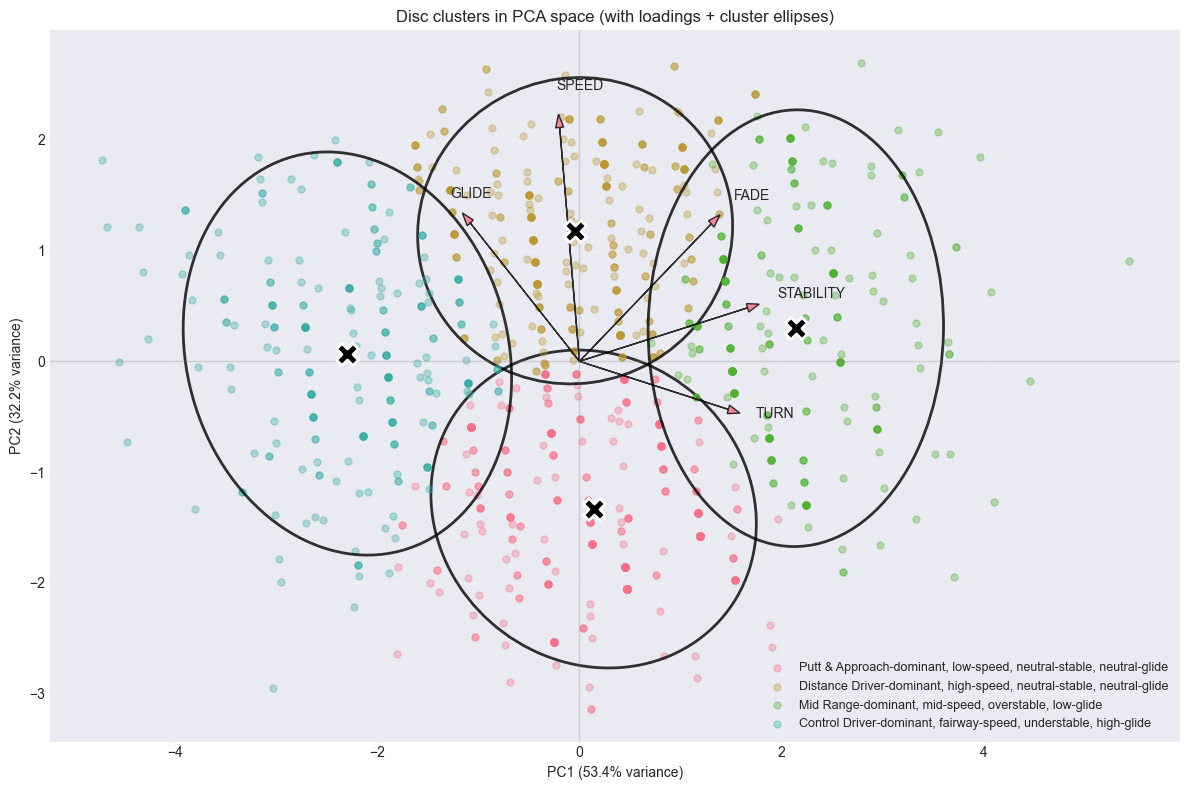

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

# Points
for cluster_id in sorted(df["Cluster"].unique()):
    d = df[df["Cluster"] == cluster_id]
    label = d["ClusterName"].iloc[0] if "ClusterName" in df.columns else f"Cluster {cluster_id}"

    ax.scatter(d["PC1"], d["PC2"], alpha=0.35, s=25, label=label)
    add_confidence_ellipse(d["PC1"], d["PC2"], ax, n_std=2.0, fill=False, lw=2, alpha=0.8)

# Centroids (K Means centers are in scaled feature space)
centers_pca = pca.transform(kmeans_final.cluster_centers_)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1],
           marker="X", s=250, c="black", edgecolors="white", linewidths=2, zorder=5)

# # Annotate centroid labels
# for i, (cx, cy) in enumerate(centers_pca):
#     name = (df.loc[df["Cluster"] == i, "ClusterName"].iloc[0]
#             if "ClusterName" in df.columns else f"Cluster {i}")
#     ax.text(cx, cy, f"  {name}", fontsize=10, va="center", ha="left")


loadings = pca.components_.T

# Scale arrows to plot nicely
arrow_scale = 3.0
for feat, (lx, ly) in zip(features, loadings):
    ax.arrow(0, 0, lx * arrow_scale, ly * arrow_scale,
             head_width=0.08, head_length=0.12, length_includes_head=True, alpha=0.8)
    ax.text(lx * arrow_scale * 1.1, ly * arrow_scale * 1.1, feat, fontsize=10)

# Cosmetics
ax.axhline(0, color="grey", lw=1, alpha=0.3)
ax.axvline(0, color="grey", lw=1, alpha=0.3)

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
ax.set_title("Disc clusters in PCA space (with loadings + cluster ellipses)")
ax.legend(loc="best", fontsize=9)
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

## Save Results

In [13]:
# Save clustered data
output_path = Path('../data/processed/disc_golf_clustered.csv')
df.to_csv(output_path, index=False)
print(f"Clustered data saved to: {output_path}")

# Save cluster profiles
cluster_summary = pd.DataFrame({
    'Cluster': range(optimal_k),
    'Count': df['Cluster'].value_counts().sort_index().values,
    'Avg_Speed': cluster_means['SPEED'].values,
    'Avg_Glide': cluster_means['GLIDE'].values,
    'Avg_Stability': cluster_means['STABILITY'].values
})

summary_path = Path('../data/processed/cluster_summary.csv')
cluster_summary.to_csv(summary_path, index=False)
print(f"Cluster summary saved to: {summary_path}")

print("\nClustering methodology demonstration complete!")

Clustered data saved to: ..\data\processed\disc_golf_clustered.csv
Cluster summary saved to: ..\data\processed\cluster_summary.csv

Clustering methodology demonstration complete!


## Save Model

In [14]:
# Persist clustering artifacts for reuse
from pathlib import Path
import joblib

models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

kmeans_path = models_dir / 'disc_cluster_model.pkl'
scaler_path = models_dir / 'disc_cluster_scaler.pkl'
features_path = models_dir / 'disc_cluster_features.pkl'

joblib.dump(kmeans_final, kmeans_path)
joblib.dump(scaler, scaler_path)
joblib.dump(available_features, features_path)

print(f"K-Means model saved to: {kmeans_path}")
print(f"Scaler saved to: {scaler_path}")
print(f"Feature list saved to: {features_path}")

K-Means model saved to: ..\models\disc_cluster_model.pkl
Scaler saved to: ..\models\disc_cluster_scaler.pkl
Feature list saved to: ..\models\disc_cluster_features.pkl


## Methodology Validation

**What We Demonstrated:**
- K-Means clustering identifies natural groupings in data
- Elbow method + Silhouette Score find optimal K, given the data's setup
- Standardization matters for distance-based algorithms
- PCA enables visualization of high-dimensional clusters
- Cluster profiles are interpretable and actionable

**With GameProofer Data:**
- Cluster players by: efficiency ratios, consistency, technique angles
- Discover 3-5 natural skill levels without labels
- Use cluster assignments as training labels for classifier
- Enable personalized coaching based on skill group characteristics

## Next Steps
See `03_classification_model.ipynb` for supervised learning on cluster labels

1. **Load clustered labels:** Read the clustered dataset saved from Notebook 02 (the file containing the `Cluster` column).
2. **Prepare training data:** Set `Cluster` as the target, use the same five flight features (SPEED, GLIDE, TURN, FADE, STABILITY) as inputs, and perform a stratified train/test split.
3. **Standardize inputs:** Fit a `StandardScaler` on the training set and apply it to train/test to match the assumptions used in the pipeline.
4. **Train the classifier:** Fit a Random Forest classifier to predict cluster membership (turning our unsupervised clusters into a supervised “assignment” model).
5. **Evaluate and diagnose:** Report test accuracy + cross-validation, then review confusion matrix, per-class metrics, and feature importance to confirm the model is reliable and interpretable.
6. **Persist artifacts:** Save the trained model (and related preprocessing artifacts) for consistent reuse in later notebooks / handoff to Notebook 04.
